In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import sklearn
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time
t = time.time()

# 1. Sentiment140 préprocessée 

In [2]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if  NEGATION:
    file += "_neg"
df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2"))
df.head(10)

,sentiment,id,date,query_string,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww that is a bummer you shoulda got david ca...
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can not update his facebook b...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no it is not behaving at all i am mad why am i...
5,Negative,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not the whole crew
6,Negative,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need a hug
7,Negative,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains a bit only a bi...
8,Negative,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope they did not have it
9,Negative,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que me muera


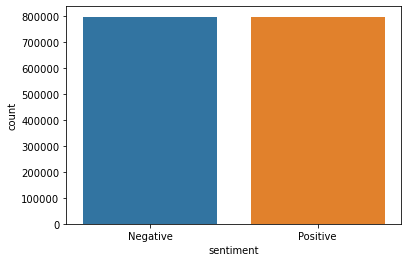

In [3]:
sns.countplot(x='sentiment', data=df)
plt.show()

## 1.1. Fréquence des mots

In [4]:
vectorizer = CountVectorizer(max_features=1000)
vectorizer.fit(df.text)

neg_matrix = vectorizer.transform(df[df.sentiment == 'Negative'].text)
pos_matrix = vectorizer.transform(df[df.sentiment == 'Positive'].text)

In [5]:
print(df[df.sentiment == 'Negative'].iloc[1].text)
print(neg_matrix[1])
liste = vectorizer.get_feature_names()
print([liste[i] for i in neg_matrix[1].tocoo().col])

is upset that he can not update his facebook by texting it and might cry as a result school today also blah
  (0, 25)	1
  (0, 32)	1
  (0, 46)	1
  (0, 119)	1
  (0, 126)	1
  (0, 168)	1
  (0, 249)	1
  (0, 364)	1
  (0, 382)	1
  (0, 425)	1
  (0, 426)	1
  (0, 523)	1
  (0, 578)	1
  (0, 703)	1
  (0, 817)	1
  (0, 847)	1
  (0, 884)	1
  (0, 887)	1
['also', 'and', 'as', 'by', 'can', 'cry', 'facebook', 'he', 'his', 'is', 'it', 'might', 'not', 'school', 'that', 'today', 'update', 'upset']


In [6]:
neg_tf = np.sum(neg_matrix,axis=0)
pos_tf = np.sum(pos_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],
                            columns=vectorizer.get_feature_names()
                           ).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', 
                         ascending=False
                        ).iloc[:10]

,negative,positive,total
to,344216,272476,616692
the,258047,266160,524207
is,202625,180106,382731
you,129314,232713,362027
not,242055,105213,347268
my,190852,125978,316830
it,157550,147903,305453
and,153963,149641,303604
am,139140,100996,240136
in,115541,101165,216706


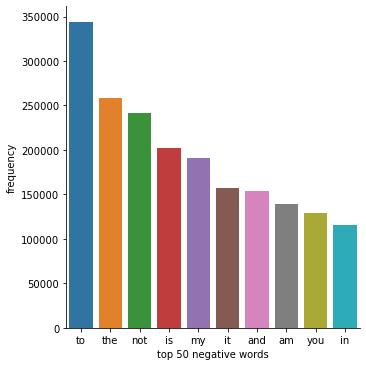

In [7]:
df1 = term_freq_df.sort_values(by='negative', ascending=False).head(10)
g = sns.catplot(x='index', y="negative", kind='bar', data=df1.reset_index())
g.set_axis_labels('top 50 negative words', 'frequency')
plt.show()

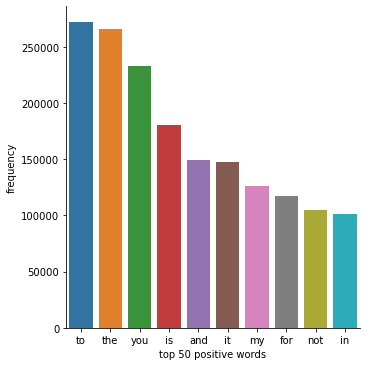

In [8]:
df2 = term_freq_df.sort_values(by='positive', ascending=False).head(10)
g = sns.catplot(x='index', y="positive", kind='bar', data=df2.reset_index())
g.set_axis_labels('top 50 positive words', 'frequency')
plt.show()

In [9]:
def term_frequency(df, column_name, N=10):
    vectorizer = CountVectorizer(max_features=N)
    vectorizer.fit(df.text)
    
    categories = list(set(df[column_name]))
    catA, catB = categories[0], categories[1]

    A_matrix = vectorizer.transform(df[df[column_name] == catA].text)
    B_matrix = vectorizer.transform(df[df[column_name] == catB].text)
    
    A_tf = np.sum(A_matrix,axis=0)
    B_tf = np.sum(B_matrix,axis=0)
    A = np.squeeze(np.asarray(A_tf))
    B = np.squeeze(np.asarray(B_tf))

    term_freq_df = pd.DataFrame([A,B],
                                columns=vectorizer.get_feature_names()
                               ).transpose()
    term_freq_df.columns = [catA, catB]
    
    nb_mots_A = CountVectorizer().fit_transform(df[df[column_name] == catA].text).sum()
    nb_mots_B = CountVectorizer().fit_transform(df[df[column_name] == catB].text).sum()

#     term_freq_df['total'] = term_freq_df[catA] + term_freq_df[catB]
#     term_freq_df.sort_values(by='total', 
#                              ascending=False
#                             ).iloc[:10]

    term_freq_df[catA] /= nb_mots_A
    term_freq_df[catB] /= nb_mots_B
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    dfA = term_freq_df.sort_values(by=catA, ascending=False).head(N)
    sns.barplot(x='index', y=catA, data=dfA.reset_index(), ax=axes[0])
    axes[0].set(xlabel=f'Top {N} {catA} words', ylabel='frequency')
    axes[0].tick_params('x', labelrotation=45)
    
    dfB = term_freq_df.sort_values(by=catB, ascending=False).head(N)
    g = sns.barplot(x='index', y=catB, data=dfB.reset_index(), ax=axes[1])
    axes[1].set(xlabel=f'Top {N} {catB} words', ylabel='frequency')
    axes[1].tick_params('x', labelrotation=45)
    
    ylim_0 = axes[0].get_ylim()[1]
    ylim_1 = axes[1].get_ylim()[1]
    ylim_max = max(ylim_0, ylim_1)
    axes[0].set_ylim((0, ylim_max))
    axes[1].set_ylim((0, ylim_max))

    fig.tight_layout()
    plt.show()

stop_words: False, lemmatization: False, negation: False


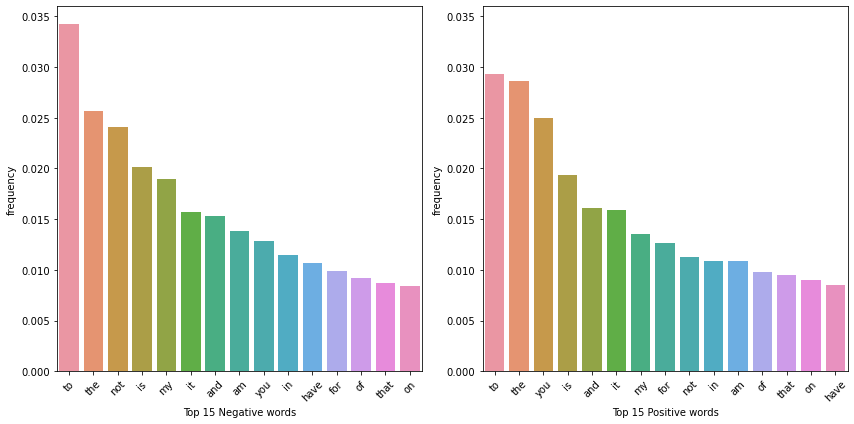

stop_words: False, lemmatization: False, negation: True


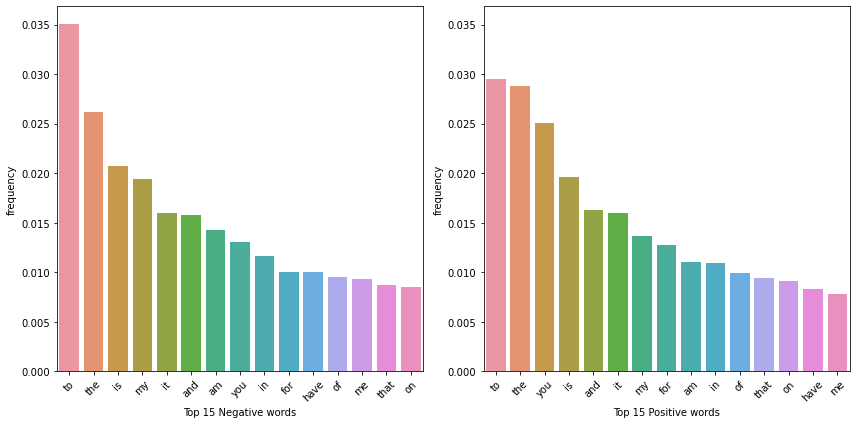

stop_words: False, lemmatization: True, negation: False


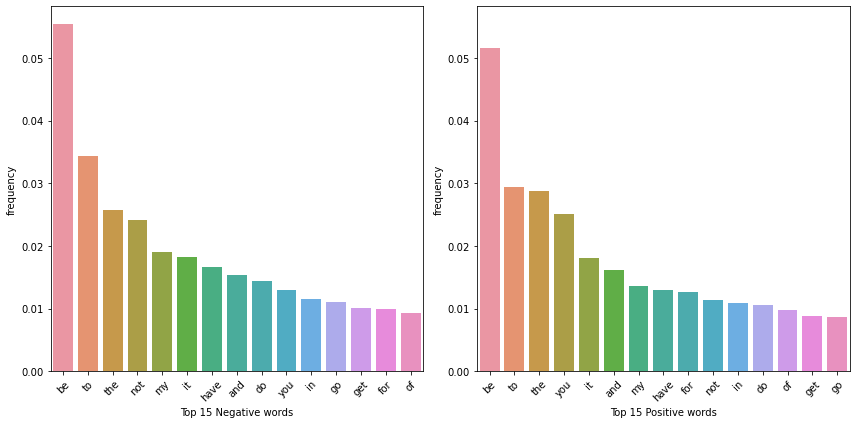

stop_words: False, lemmatization: True, negation: True


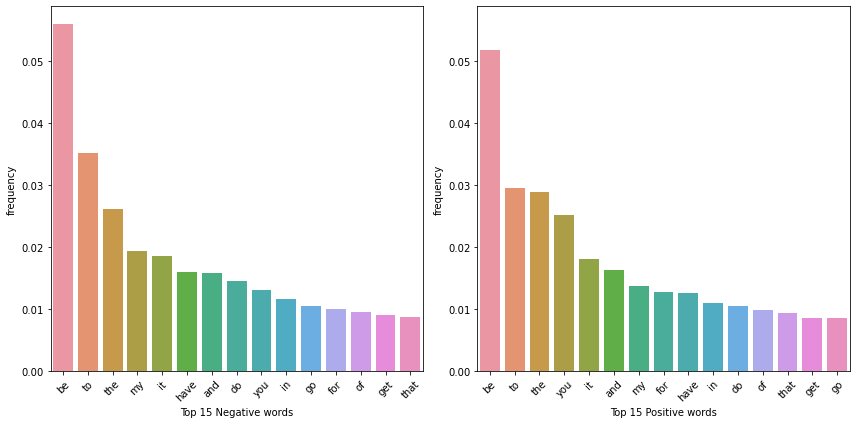

stop_words: True, lemmatization: False, negation: False


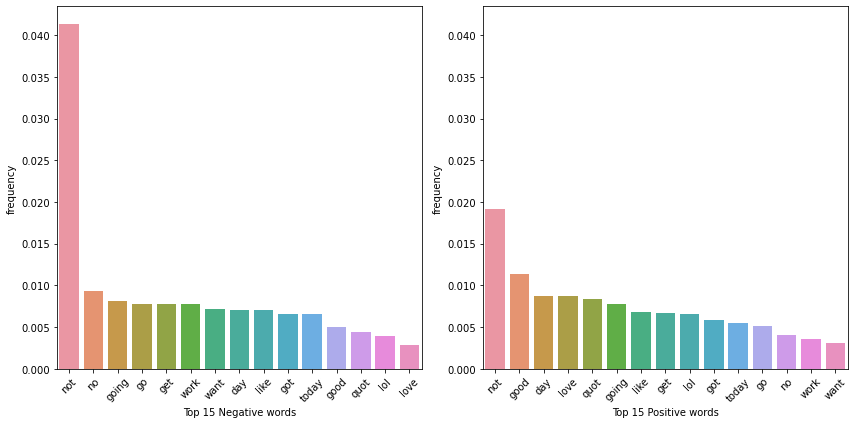

stop_words: True, lemmatization: False, negation: True


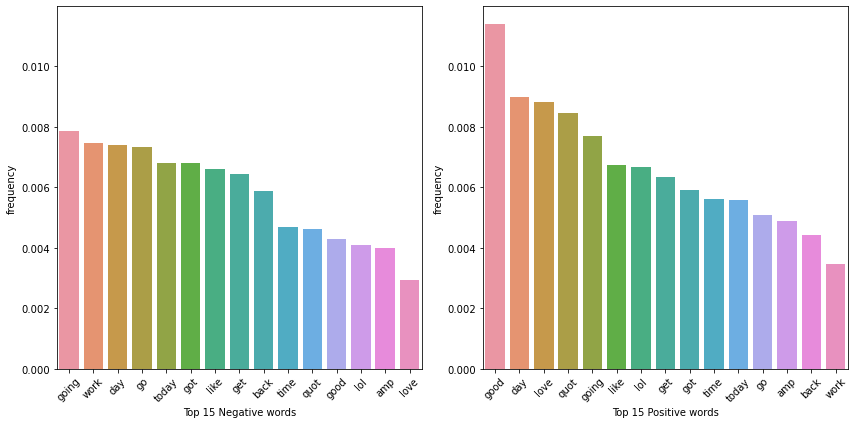

stop_words: True, lemmatization: True, negation: False


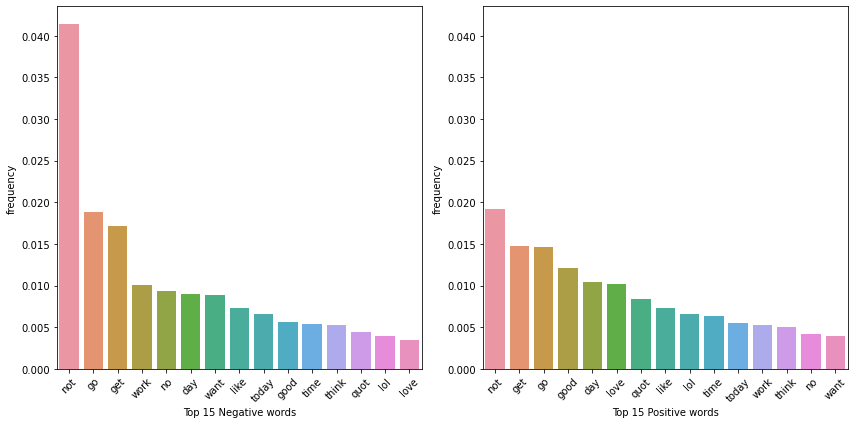

stop_words: True, lemmatization: True, negation: True


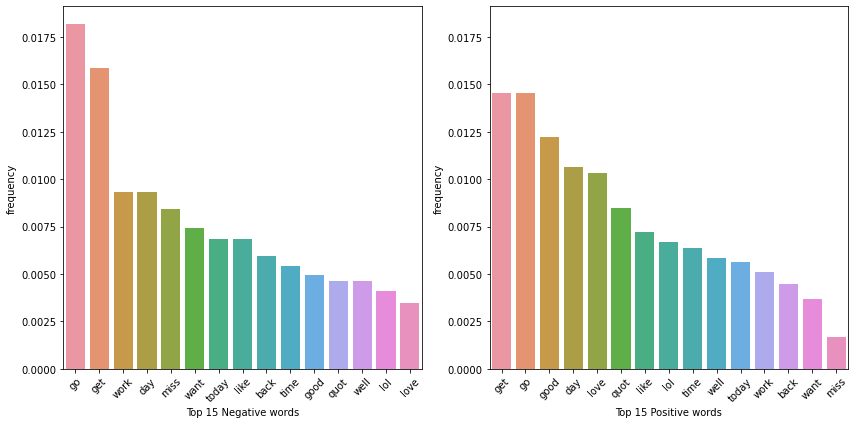

Wall time: 7min 15s


In [10]:
%%time
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            file = "train"
            if stop_words:
                file += "_stop"
            if lemmatization:
                file += "_lemm"
            if  negation:
                file += "_neg"
            df_temp = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2"))
            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            term_frequency(df_temp, 'sentiment', 15)   

## 1.2. Word cloud

In [11]:
positive_text = " ".join(df[df.sentiment == "Positive"].text.to_numpy().tolist())
negative_text = " ".join(df[df.sentiment == "Negative"].text.to_numpy().tolist())

positive_cloud = WordCloud(stopwords=['get', 'go'], max_words=50, background_color="white").generate(positive_text)
negative_cloud = WordCloud(stopwords=['get', 'go'], max_words=50, background_color="white").generate(negative_text)

In [12]:
def show_word_cloud(cloud, title):
    plt.figure(figsize = (16, 10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show();

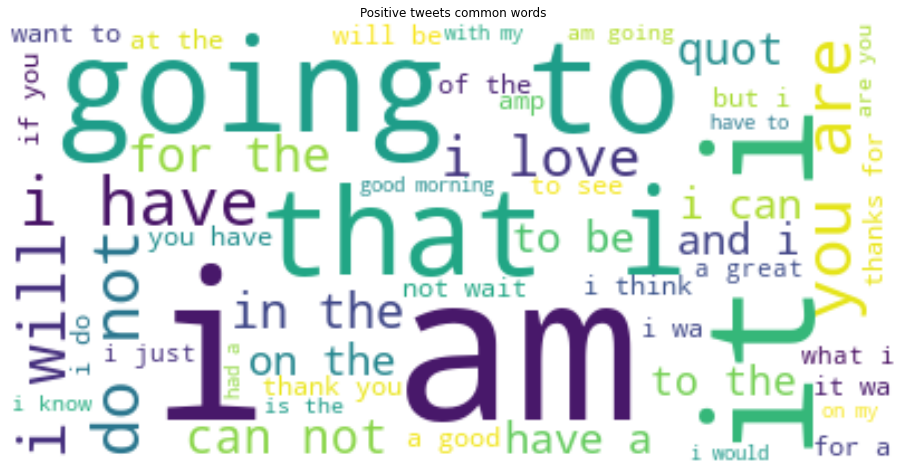

In [13]:
show_word_cloud(positive_cloud, "Positive tweets common words")

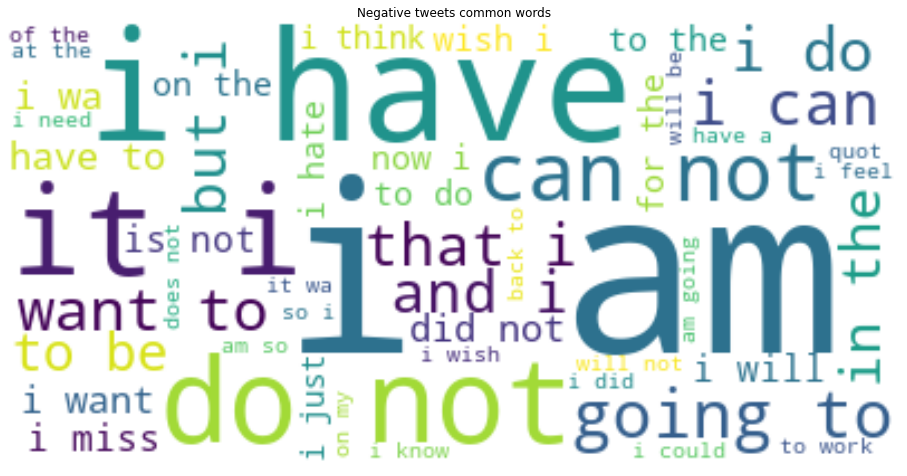

In [14]:
show_word_cloud(negative_cloud, "Negative tweets common words")

# 2. Tweets webscrapés
## 2.1. Fréquence des mots

stop_words: False, lemmatization: False, negation: False


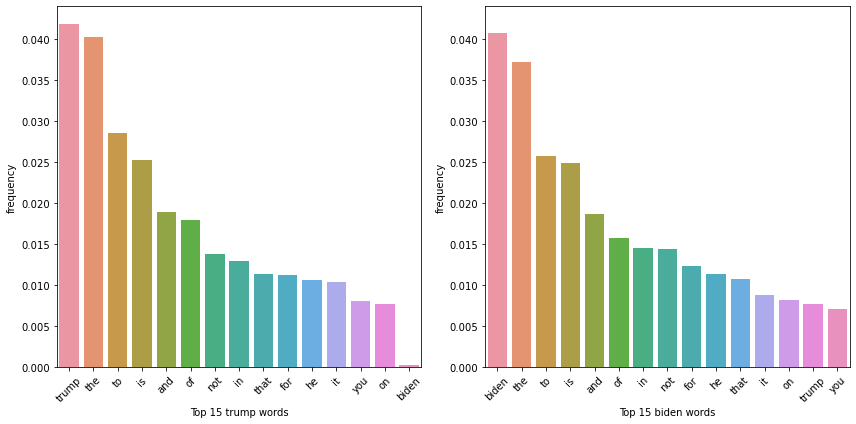

stop_words: False, lemmatization: False, negation: True


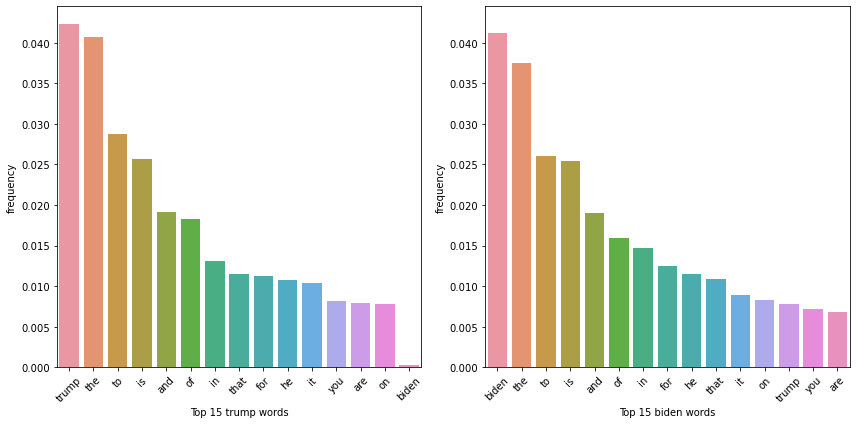

stop_words: False, lemmatization: True, negation: False


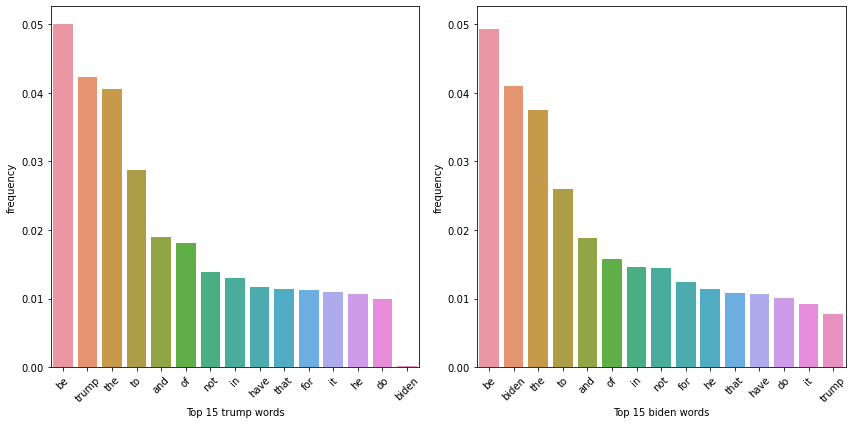

stop_words: False, lemmatization: True, negation: True


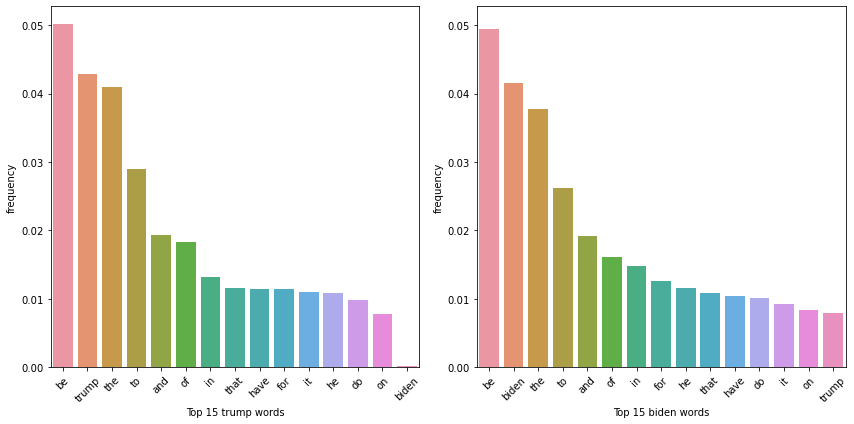

stop_words: True, lemmatization: False, negation: False


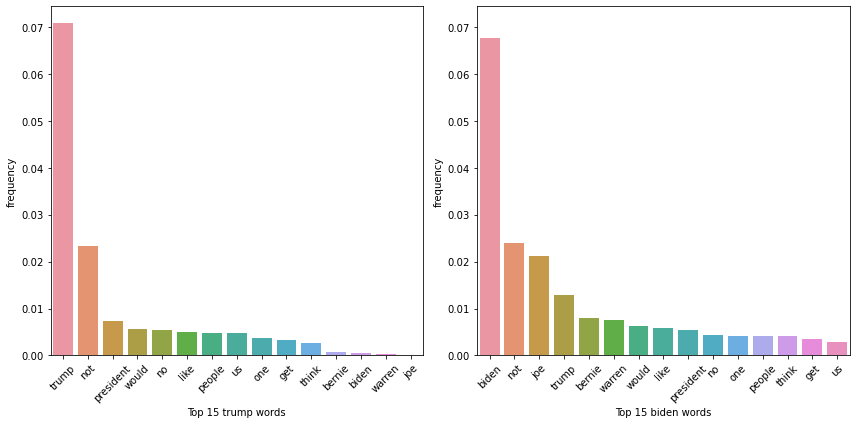

stop_words: True, lemmatization: False, negation: True


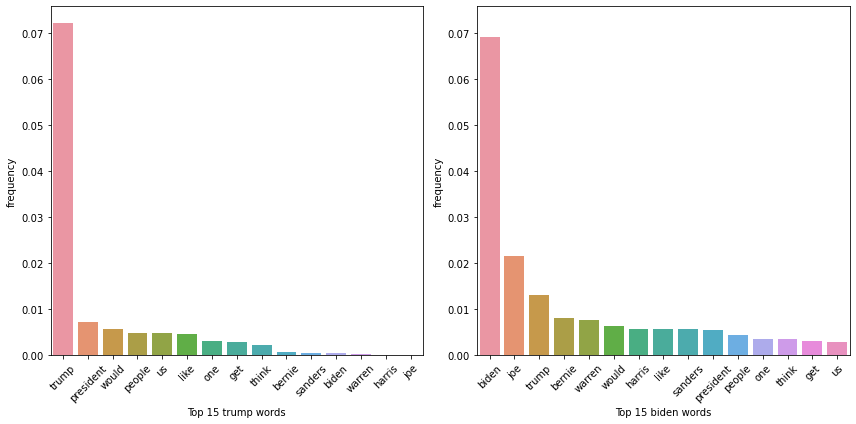

stop_words: True, lemmatization: True, negation: False


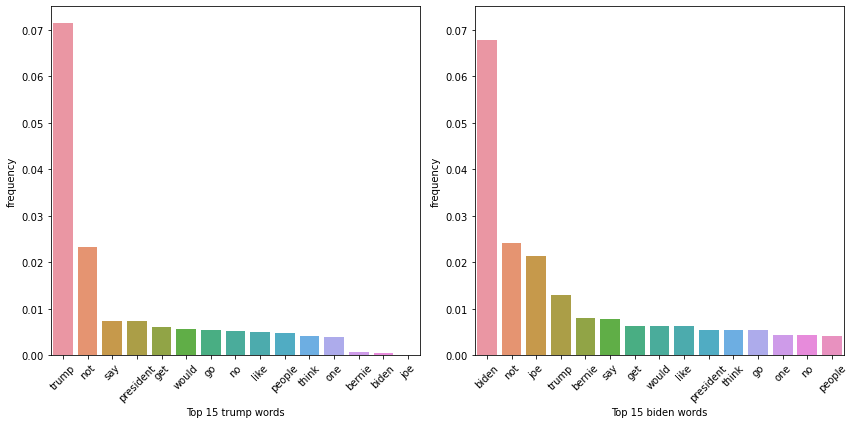

stop_words: True, lemmatization: True, negation: True


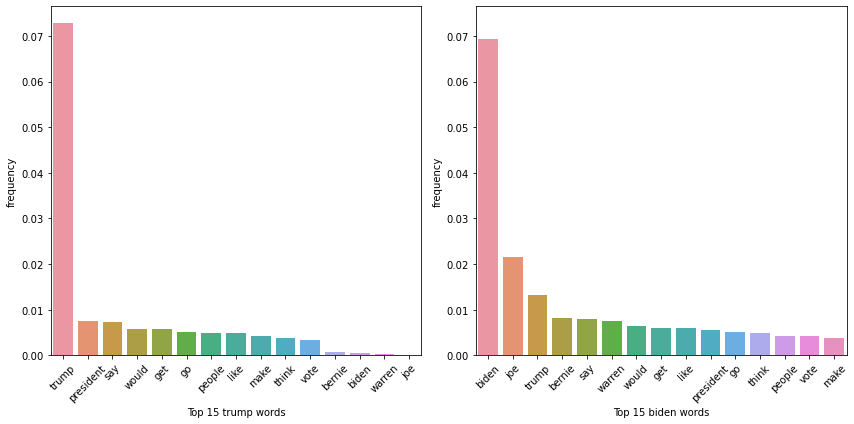

In [15]:
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            file = "web"
            if stop_words:
                file += "_stop"
            if lemmatization:
                file += "_lemm"
            if  negation:
                file += "_neg"
            df_temp = pd.read_pickle(os.path.join("data", "web", file+".bz2")   )
            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            term_frequency(df_temp, 'search', 15)   

## 2.2. Corrélations

In [17]:
STOP_WORDS = True
LEMMATIZATION = True
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df = pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2"))
df.head(10)
df['sentiment_bool']=(df['sentiment']=='Positive').astype(int)

In [18]:
def corr_matrix(df, N, vectorizer):
    vectorizer = vectorizer(max_features=N)
    X = df.text.to_list()
    X = vectorizer.fit_transform(X)
    X = X.toarray().transpose()
    
    features = vectorizer.get_feature_names()
    for i in range(len(features)):
        df[features[i]] = X[i]
        
    fig = plt.figure(figsize=(N/2, N/2))
    columns = ['sentiment_bool'] + list(df.columns[-N:])
    sns.set(font_scale=1.5)
    corrMatrix = df[columns].corr()
    corrMatrix = np.abs(corrMatrix)
    sns.heatmap(corrMatrix, cmap="rocket_r", annot=False)
    plt.show()

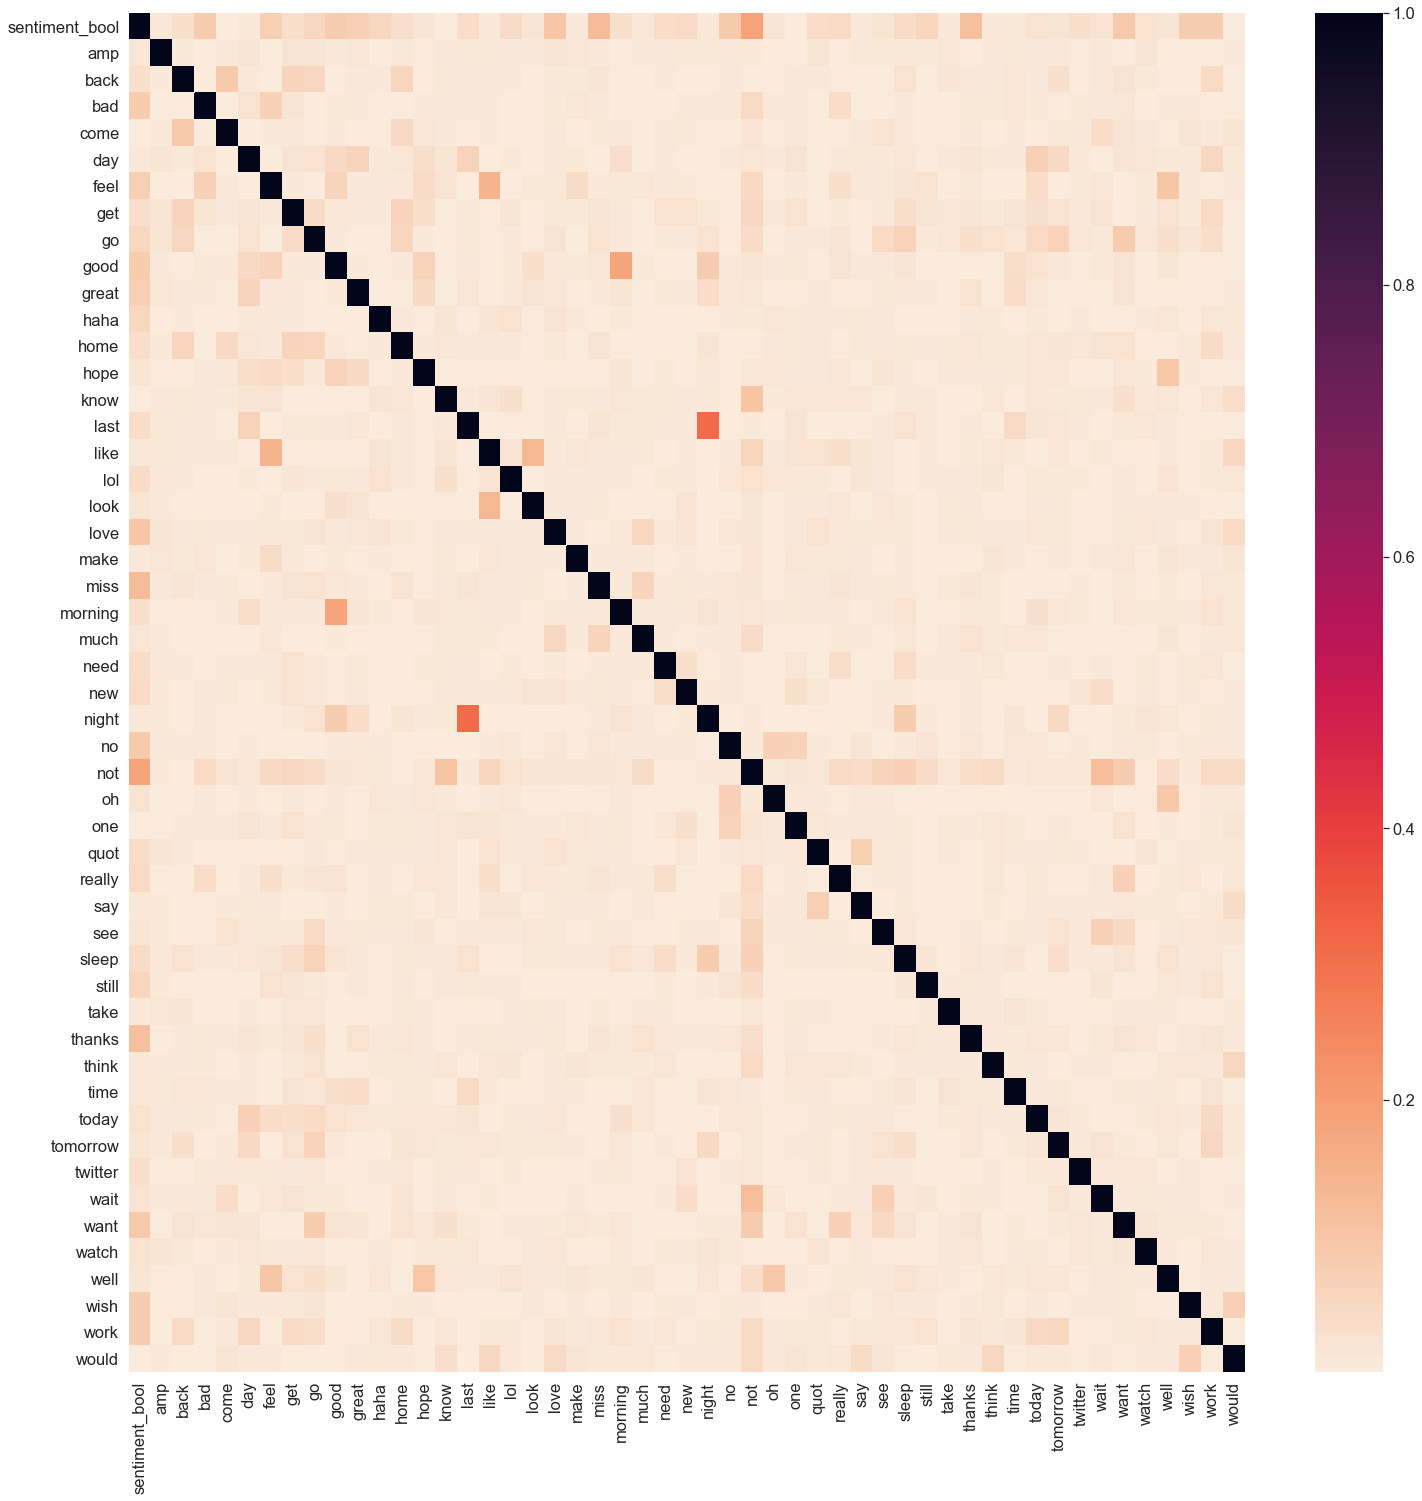

In [19]:
corr_matrix(df, 50, CountVectorizer)

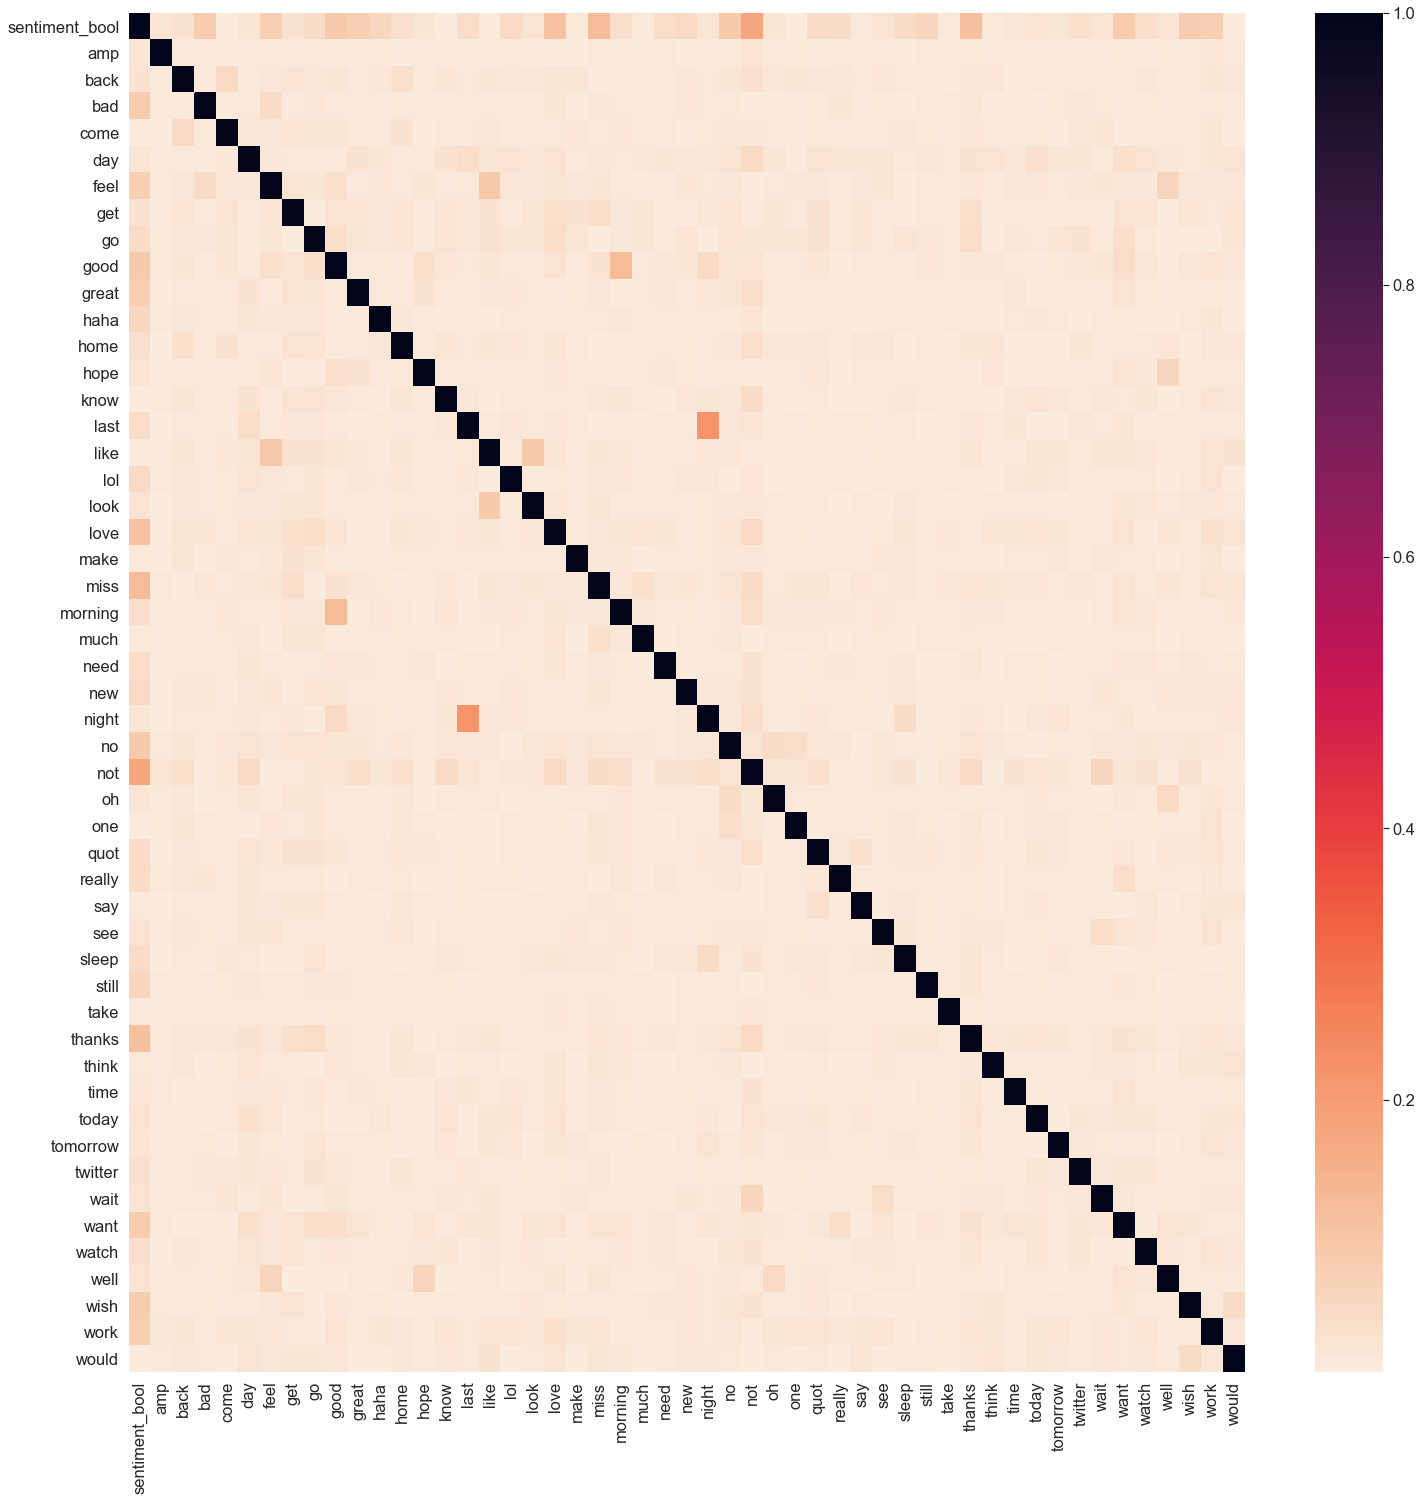

In [20]:
corr_matrix(df, 50, TfidfVectorizer)

In [21]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:10:59
